In [1]:
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd
import scipy
from scipy.stats import chi2
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import type_of_target
from scipy import stats
import xgboost as xgb
from sklearn.metrics import auc,roc_curve,roc_auc_score
from sklearn.externals import joblib
import graphviz
%matplotlib inline 

In [26]:
#分数转化
def score_ys(datain,p,PDO,basepoint):
    cs=np.log(p/(1-p))
    B=PDO/np.log(2)
    A=basepoint+B*np.log(1/50)
    score=np.round(A-cs*B)
    datain['score'] = score
    datain['p']=p

In [27]:
def plot_psi(actual,expected,title = 'PSI',quant=20):
    minv = min(min(actual),min(expected))
    maxv = max(max(actual),max(expected))
    step = 1.0*(maxv-minv)/quant
    acnt = []
    ecnt = []
    s,e = minv,minv+step
    act = np.array(actual)
    ex = np.array(expected)

    while e <= maxv:
        acnt.append(((act>=s) & (act < e)).sum())
        ecnt.append(((ex>=s )& (ex < e)).sum())
        s = e
        e = e+step

    arate = np.array(acnt)/ len(actual)
    erate = np.array(ecnt)/ len(expected)

    arate[arate==0] = 0.000001
    erate[erate==0] = 0.000001

    psi = np.sum((arate - erate)*np.log(arate/erate))
    #psi = psi.sum()

    x1 = np.linspace(0,len(acnt)-1,len(acnt)) - 0.2
    x2 = np.linspace(0,len(acnt)-1,len(acnt)) + 0.2
    plt.bar(x1, arate*100, alpha=0.9, width = 0.4, facecolor = 'orange', edgecolor = 'white', label='Actual', lw=0.2)
    plt.bar(x2, erate*100, alpha=0.9, width = 0.4, facecolor = 'lightblue', edgecolor = 'white', label='Expected', lw=0.2)
    plt.legend()
    plt.suptitle(title)
    plt.title('({})'.format(psi))
    ax = plt.axes()
    from matplotlib.ticker import FormatStrFormatter
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f%%'))
    plt.show()
    return psi

In [28]:
def pct_rank_qcut(datain,series,n):
   
    """离散型变量分箱"""
    edages = pd.Series([i/n for i in range(n)]) #生成分位数
    
    func = lambda x:(edages >= x).idxmax() #argmax()返回最大值对应的索引,索引从0开始计算； func函数：输入x输出，输出百分位数对应的索引值
    datain[series + '_bin' ] = datain[series].rank(na_option = 'top',pct=True).astype(float).apply(func) 

In [29]:
#统计分布
def score_fb(indata,var,var_bin):
    """连续型变量分箱"""
    score_fb = pd.DataFrame()
    g = indata[[var,var_bin,'default']].groupby(indata[var_bin])
    n = len(indata)
    good_n = len(indata[indata['default'].isin([0.0])])
    bad_n = len(indata[indata['default'].isin([1.0])])
    value_max = list(g.max()[var])
    value_min = list(g.min()[var])
    value = list(g.groups.keys())
    
    
    var_name = []
    bin_n = []
    bin_good_n = []
    bin_bad_n = []
    bin_rate = []
    bad_rate = []
    good_rate = []
    for i in range(0,len(g.groups)):
        var_name1 =var_bin
        bin_n1 = len(g.get_group(value[i]))
        bin_good_n1 = len(g.get_group(value[i])[g.get_group(value[i])['default'].isin([0.0])])
        bin_bad_n1 = len(g.get_group(value[i])[g.get_group(value[i])['default'].isin([1.0])])
        bin_rate1 = bin_n1/n
        bad_rate1 = bin_bad_n1/bin_n1
        good_rate1 = bin_good_n1/bin_n1
            
 
        bin_n.append(bin_n1)
        bin_good_n.append(bin_good_n1)
        bin_bad_n.append(bin_bad_n1)
        var_name.append(var_name1)
        bin_rate.append(bin_rate1)
        bad_rate.append(bad_rate1)
        good_rate.append(good_rate1)
             
    cols = ['var_name','value','value_min','value_max','bin_n','bin_good_n','bin_bad_n','bin_rate','bad_rate']
    num1 = pd.DataFrame(np.array([var_name,value,value_min,value_max,bin_n,bin_good_n,bin_bad_n,bin_rate,bad_rate]).T,columns =cols)
    score_fb= score_fb.append(num1,ignore_index=False)
    score_fb['qujian'] =  '['+score_fb['value_min']+','+score_fb['value_max']+']'
    score_fb['avg'] = indata['default'].value_counts(normalize=True)[1]
    score_fb = score_fb.sort_values('value_min')
    return score_fb

In [31]:
import os
os.chdir(r'E:\AnalystPersonal\chenxiaoyan\催收\催收929\xgboost')

In [32]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')

In [8]:
drop_m12 = pd.read_csv('drop_m12.csv',na_values =['',' ','.','-1','-2'],engine='python')

In [9]:
drop_m12.shape

(4622, 188)

In [10]:
drop_m12['default'].value_counts(normalize=True)

1    0.917352
0    0.082648
Name: default, dtype: float64

In [11]:
c = drop_m12.default.replace({0:1,1:0})
drop_m12['default']=c
oot = drop_m12.copy()

In [9]:
#调用模型

In [12]:
#分账龄建模 - m1-m2 - 使用相同变量
train_m12 = train_df[train_df['zl'].isin([1,2])][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
test_m12 = test_df[test_df['zl'].isin([1,2])][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
oot_m12 = oot[oot['zl'].isin([1,2])][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
print(train_m12.shape,test_m12.shape,oot_m12.shape)
print(train_m12['default'].value_counts(normalize=True),test_m12['default'].value_counts(normalize=True),oot_m12['default'].value_counts(normalize=True))


(26014, 10) (6499, 10) (4622, 10)
0    0.857577
1    0.142423
Name: default, dtype: float64 0    0.860902
1    0.139098
Name: default, dtype: float64 0    0.917352
1    0.082648
Name: default, dtype: float64


In [22]:
oot_m12['']

0         37.0
1         44.0
2         83.0
3         83.0
4       -832.0
5       -801.0
6        -54.0
7       -923.0
8       -847.0
9       -405.0
10      -467.0
11      -938.0
12      -436.0
13      -862.0
14      -420.0
15      -436.0
16      -467.0
17      -512.0
18      -162.0
19      -558.0
20      -847.0
21      -451.0
22      -436.0
23      -512.0
24      -923.0
25      -801.0
26      -420.0
27      -436.0
28      -436.0
29      -832.0
         ...  
4592    -677.0
4593    -312.0
4594   -1042.0
4595    -314.0
4596    -313.0
4597    -314.0
4598    -679.0
4599    -314.0
4600    -314.0
4601    -314.0
4602    -684.0
4603   -1049.0
4604    -684.0
4605    -319.0
4606    -319.0
4607    -319.0
4608    -319.0
4609    -319.0
4610    -680.0
4611    -315.0
4612    -317.0
4613    -317.0
4614    -317.0
4615    -317.0
4616   -1047.0
4617    -682.0
4618    -317.0
4619    -317.0
4620    -317.0
4621    -318.0
Name: last_pay_days, Length: 4622, dtype: float64

In [13]:
booster= joblib.load(r'm12.m')

In [189]:
booster.best_ntree_limit

73

In [196]:
pd.Series(booster.get_fscore()).sort_values(ascending=False)

last_pay_days        146
recent_first_days    121
fp_camt_pct           90
o_interest            31
dtype: int64

In [17]:
X_train = train_m12.drop(['default','zl','o_total_amount','return_amt'],axis=1)
xgb_train =  xgb.DMatrix(X_train,label=train_m12.default)
xgb_test = xgb.DMatrix(test_m12[X_train.columns],label=test_m12.default)
xgb_oot = xgb.DMatrix(oot_m12[X_train.columns],label=oot_m12.default)

In [15]:
booster

In [18]:
def report_performance(preds, y,cutoff = 0.5):
    ks =  stats.ks_2samp(preds[y==1], preds[y!=1]).statistic
    gini =  metrics.roc_auc_score(y,preds)*2 - 1.0
    accuracy = metrics.accuracy_score(y, np.where(preds > cutoff,1,0))
    recall = metrics.recall_score(y, np.where(preds > cutoff,1,0))
    precision = metrics.precision_score(y, np.where(preds > cutoff,1,0))
    cm = metrics.confusion_matrix(y, np.where(preds > cutoff,1,0)) 
    # fpr, tpr, thresholds = metrics.roc_curve(y,preds) 
    auc = metrics.roc_auc_score(y,preds)
    # roc_auc = metrics.auc(fpr,tpr)
    print('=======================report=================')
    print('Gini is: %-.5f \t KS is: %-.5f \t accuracy: %-.5f \t Precision: %-.5f \t Recall:%-.5f \t AUC:%-.5f' % (gini, ks, accuracy,precision,recall,auc))
    print('confusion matrix:')
    print(cm)

In [19]:
preds=booster.predict(xgb_train,ntree_limit = booster.best_ntree_limit)
preds2=booster.predict(xgb_test,ntree_limit = booster.best_ntree_limit)
preds3=booster.predict(xgb_oot,ntree_limit = booster.best_ntree_limit)
report_performance(preds, train_m12.default)
report_performance(preds2, test_m12.default)
report_performance(preds3, oot_m12.default)

=======================report=================
Gini is: 0.30168 	 KS is: 0.22058 	 accuracy: 0.85758 	 Precision: 0.00000 	 Recall:0.00000 	 AUC:0.65084
confusion matrix:
[[22309     0]
 [ 3705     0]]
=======================report=================
Gini is: 0.27394 	 KS is: 0.21074 	 accuracy: 0.86090 	 Precision: 0.00000 	 Recall:0.00000 	 AUC:0.63697
confusion matrix:
[[5595    0]
 [ 904    0]]
=======================report=================
Gini is: 0.14621 	 KS is: 0.15521 	 accuracy: 0.91735 	 Precision: 0.00000 	 Recall:0.00000 	 AUC:0.57310
confusion matrix:
[[4240    0]
 [ 382    0]]


D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
preds3

array([0.3320422 , 0.32580113, 0.3153021 , ..., 0.35533196, 0.35533196,
       0.35533196], dtype=float32)

In [84]:
score_ys(train_m12,preds,50,500)
score_ys(test_m12,preds2,50,500)
score_ys(oot_m12,preds3,50,500)

## M3-M6

In [217]:
booster= joblib.load(r'm36.m')

In [200]:
train_m36 = train_df[train_df['zl'].isin ([3,4,5,6])][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
test_m36 = test_df[test_df['zl'].isin ([3,4,5,6])][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
oot_m36 = oot[oot['zl'].isin ([3,4,5,6])][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]

In [201]:
print(train_m36.shape,test_m36.shape,oot_m36.shape)
print(train_m36['default'].value_counts(normalize=True),test_m36['default'].value_counts(normalize=True),oot_m36['default'].value_counts(normalize=True))

(49978, 10) (12677, 10) (60437, 10)
0    0.97711
1    0.02289
Name: default, dtype: float64 0    0.97602
1    0.02398
Name: default, dtype: float64 0    0.973791
1    0.026209
Name: default, dtype: float64


In [218]:
ceate_feature_map(['last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest'])#特征名列表

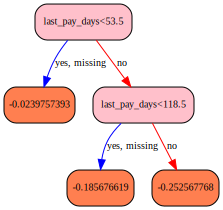

In [229]:
import re

_NODEPAT = re.compile(r'(\d+):\[(.+)\]')
_LEAFPAT = re.compile(r'(\d+):(leaf=.+)')
_EDGEPAT = re.compile(r'yes=(\d+),no=(\d+),missing=(\d+)')
_EDGEPAT2 = re.compile(r'yes=(\d+),no=(\d+)')


def _parse_node(graph, text):
    """parse dumped node"""
    match = _NODEPAT.match(text)
    if match is not None:
        node = match.group(1)
        graph.node(node, label=match.group(2), shape='box',style = 'filled,rounded',fillcolor='pink')
        return node
    match = _LEAFPAT.match(text)
    if match is not None:
        node = match.group(1)
        graph.node(node, label=match.group(2).replace('leaf=',''), shape='box',style = 'filled,rounded',fillcolor='coral')
        return node
    raise ValueError('Unable to parse node: {0}'.format(text))


def _parse_edge(graph, node, text, yes_color='#0000FF', no_color='#FF0000'):
    """parse dumped edge"""
    try:
        match = _EDGEPAT.match(text)
        if match is not None:
            yes, no, missing = match.groups()
            if yes == missing:
                graph.edge(node, yes, label='yes, missing', color=yes_color)
                graph.edge(node, no, label='no', color=no_color)
            else:
                graph.edge(node, yes, label='yes', color=yes_color)
                graph.edge(node, no, label='no, missing', color=no_color)
            return
    except ValueError:
        pass
    match = _EDGEPAT2.match(text)
    if match is not None:
        yes, no = match.groups()
        graph.edge(node, yes, label='yes', color=yes_color)
        graph.edge(node, no, label='no', color=no_color)
        return
    raise ValueError('Unable to parse edge: {0}'.format(text))


from graphviz import Digraph
booster= joblib.load(r'm36.m')
tree = booster.get_dump(fmap='xgb.fmap')[9]
tree = tree.split()
kwargs = {
        #'label': 'A Fancy Graph',
        'fontsize': '10',
        #'fontcolor': 'white',
        #'bgcolor': '#333333',
        #'rankdir': 'BT'
         }
kwargs = kwargs.copy()
#kwargs.update({'rankdir': rankdir})
graph = Digraph(format='PNG', node_attr=kwargs,edge_attr=kwargs,engine='dot')#,edge_attr=kwargs,graph_attr=kwargs,
#graph.attr(bgcolor='purple:pink', label='agraph', fontcolor='white')

yes_color='#0000FF'
no_color='#FF0000'
for i, text in enumerate(tree):
    if text[0].isdigit():
        node = _parse_node(graph, text)
    else:
        if i == 0:
            # 1st string must be node
            raise ValueError('Unable to parse given string as tree')
        _parse_edge(graph, node, text, yes_color=yes_color,no_color=no_color)

graph.render('xgb_m36_9.PNG')

graph

In [89]:
X_train = train_m36.drop(['default','o_total_amount','return_amt','zl'],axis=1)
xgb_train =  xgb.DMatrix(X_train,label=train_m36.default)
xgb_test = xgb.DMatrix(test_m36[X_train.columns],label=test_m36.default)

xgb_oot = xgb.DMatrix(oot_m36[X_train.columns],label=oot_m36.default)

preds=booster.predict(xgb_train,ntree_limit = booster.best_ntree_limit)
report_performance(preds,train_m36.default)

preds2=booster.predict(xgb_test,ntree_limit = booster.best_ntree_limit)
report_performance(preds2,test_m36.default)

preds3=booster.predict(xgb_oot,ntree_limit = booster.best_ntree_limit)
report_performance(preds3,oot_m36.default)

D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


=======================report=================
Gini is: 0.55537 	 KS is: 0.43288 	 accuracy: 0.97711 	 Precision: 0.00000 	 Recall:0.00000 	 AUC:0.77769
confusion matrix:
[[48834     0]
 [ 1144     0]]
=======================report=================
Gini is: 0.50589 	 KS is: 0.41357 	 accuracy: 0.97602 	 Precision: 0.00000 	 Recall:0.00000 	 AUC:0.75294
confusion matrix:
[[12373     0]
 [  304     0]]
=======================report=================
Gini is: 0.52420 	 KS is: 0.40072 	 accuracy: 0.97379 	 Precision: 0.00000 	 Recall:0.00000 	 AUC:0.76210
confusion matrix:
[[58853     0]
 [ 1584     0]]


In [90]:
score_ys(train_m36,preds,50,500)
score_ys(test_m36,preds2,50,500)
score_ys(oot_m36,preds3,50,500)

## M7+

In [230]:
booster= joblib.load(r'm7.m')

In [231]:
#分账龄建模 - m7+ - 使用相同变量
train_m7 = train_df[train_df['zl']>6][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
test_m7 = test_df[test_df['zl']>6][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
oot_m7 = oot[oot['zl']>6][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]

In [232]:
print(train_m7.shape,test_m7.shape,oot_m7.shape)
print(train_m7['default'].value_counts(normalize=True),test_m7['default'].value_counts(normalize=True),oot_m7['default'].value_counts(normalize=True))

(443481, 10) (110693, 10) (581786, 10)
0    0.993111
1    0.006889
Name: default, dtype: float64 0    0.993062
1    0.006938
Name: default, dtype: float64 0    0.994022
1    0.005978
Name: default, dtype: float64


In [233]:
pd.Series(booster.get_fscore()).sort_values(ascending=False)

last_pay_days                 41
recent_first_days             28
self_FR_get_SR_get_prop_6m    15
fp_camt_pct                   15
self_FR_get_SR_get_prop_tt    14
o_interest                    12
dtype: int64

In [234]:
ceate_feature_map(['last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest'])#特征名列表

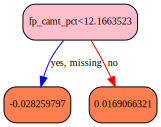

In [272]:
import re

_NODEPAT = re.compile(r'(\d+):\[(.+)\]')
_LEAFPAT = re.compile(r'(\d+):(leaf=.+)')
_EDGEPAT = re.compile(r'yes=(\d+),no=(\d+),missing=(\d+)')
_EDGEPAT2 = re.compile(r'yes=(\d+),no=(\d+)')


def _parse_node(graph, text):
    """parse dumped node"""
    match = _NODEPAT.match(text)
    if match is not None:
        node = match.group(1)
        graph.node(node, label=match.group(2), shape='box',style = 'filled,rounded',fillcolor='pink')
        return node
    match = _LEAFPAT.match(text)
    if match is not None:
        node = match.group(1)
        graph.node(node, label=match.group(2).replace('leaf=',''), shape='box',style = 'filled,rounded',fillcolor='coral')
        return node
    raise ValueError('Unable to parse node: {0}'.format(text))


def _parse_edge(graph, node, text, yes_color='#0000FF', no_color='#FF0000'):
    """parse dumped edge"""
    try:
        match = _EDGEPAT.match(text)
        if match is not None:
            yes, no, missing = match.groups()
            if yes == missing:
                graph.edge(node, yes, label='yes, missing', color=yes_color)
                graph.edge(node, no, label='no', color=no_color)
            else:
                graph.edge(node, yes, label='yes', color=yes_color)
                graph.edge(node, no, label='no, missing', color=no_color)
            return
    except ValueError:
        pass
    match = _EDGEPAT2.match(text)
    if match is not None:
        yes, no = match.groups()
        graph.edge(node, yes, label='yes', color=yes_color)
        graph.edge(node, no, label='no', color=no_color)
        return
    raise ValueError('Unable to parse edge: {0}'.format(text))


from graphviz import Digraph
booster= joblib.load(r'm7.m')
tree = booster.get_dump(fmap='xgb.fmap')[33]
tree = tree.split()
kwargs = {
        #'label': 'A Fancy Graph',
        'fontsize': '10',
        #'fontcolor': 'white',
        #'bgcolor': '#333333',
        #'rankdir': 'BT'
         }
kwargs = kwargs.copy()
#kwargs.update({'rankdir': rankdir})
graph = Digraph(format='PNG', node_attr=kwargs,edge_attr=kwargs,engine='dot')#,edge_attr=kwargs,graph_attr=kwargs,
#graph.attr(bgcolor='purple:pink', label='agraph', fontcolor='white')

yes_color='#0000FF'
no_color='#FF0000'
for i, text in enumerate(tree):
    if text[0].isdigit():
        node = _parse_node(graph, text)
    else:
        if i == 0:
            # 1st string must be node
            raise ValueError('Unable to parse given string as tree')
        _parse_edge(graph, node, text, yes_color=yes_color,no_color=no_color)

graph.render('xgb_m7_33.PNG')

graph

In [96]:
X_train = train_m7.drop(['default','o_total_amount','return_amt','zl'],axis=1)
xgb_train =  xgb.DMatrix(X_train,label=train_m7.default)
xgb_test = xgb.DMatrix(test_m7[X_train.columns],label=test_m7.default)

xgb_oot = xgb.DMatrix(oot_m7[X_train.columns],label=oot_m7.default)
preds=booster.predict(xgb_train,ntree_limit = booster.best_ntree_limit)
report_performance(preds,train_m7.default)

preds2=booster.predict(xgb_test,ntree_limit = booster.best_ntree_limit)
report_performance(preds2,test_m7.default)

preds3=booster.predict(xgb_oot,ntree_limit = booster.best_ntree_limit)
report_performance(preds3,oot_m7.default)

D:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


=======================report=================
Gini is: 0.67698 	 KS is: 0.53320 	 accuracy: 0.99311 	 Precision: 0.00000 	 Recall:0.00000 	 AUC:0.83849
confusion matrix:
[[440426      0]
 [  3055      0]]
=======================report=================
Gini is: 0.68843 	 KS is: 0.56885 	 accuracy: 0.99306 	 Precision: 0.00000 	 Recall:0.00000 	 AUC:0.84422
confusion matrix:
[[109925      0]
 [   768      0]]
=======================report=================
Gini is: 0.65335 	 KS is: 0.51934 	 accuracy: 0.99402 	 Precision: 0.00000 	 Recall:0.00000 	 AUC:0.82667
confusion matrix:
[[578308      0]
 [  3478      0]]


In [97]:
score_ys(train_m7,preds,50,500)
score_ys(test_m7,preds2,50,500)
score_ys(oot_m7,preds3,50,500)

In [25]:
train1 = train_m12[['zl','p','score','default','o_total_amount','return_amt','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest']]
train2 = train_m36[['zl','p','score','default','o_total_amount','return_amt','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest']]
train3 = train_m7[['zl','p','score','default','o_total_amount','return_amt','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest']]
train = pd.concat([train1,train2,train3])

KeyError: "['p' 'score'] not in index"

In [99]:
test1 = test_m12[['zl','p','score','default','o_total_amount','return_amt','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest']]
test2 = test_m36[['zl','p','score','default','o_total_amount','return_amt','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest']]
test3 = test_m7[['zl','p','score','default','o_total_amount','return_amt','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest']]
test = pd.concat([test1,test2,test3])

In [100]:
oot1 = oot_m12[['zl','p','score','default','o_total_amount','return_amt','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest']]
oot2 = oot_m36[['zl','p','score','default','o_total_amount','return_amt','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest']]
oot3 = oot_m7[['zl','p','score','default','o_total_amount','return_amt','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt','recent_first_days','fp_camt_pct','o_interest']]
oot_ = pd.concat([oot_m12,oot_m36,oot_m7])

In [256]:
oot_

,default,zl,last_pay_days,self_FR_get_SR_get_prop_6m,self_FR_get_SR_get_prop_tt,recent_first_days,fp_camt_pct,o_interest,o_total_amount,return_amt,score,p,score_bin,last_pay_days_bin
17707,0,2,81.0,0.96,0.967742,822.0,1.121964,335.76,5444.95,NaN,274.0,0.315302,1,1
17738,0,2,52.0,1.00,1.000000,973.0,1.119498,160.15,5443.22,NaN,273.0,0.316987,1,1
17812,0,2,62.0,1.00,1.000000,856.0,1.072156,472.82,8656.00,NaN,272.0,0.319896,1,1
17815,0,2,52.0,1.00,1.000000,973.0,1.121009,208.38,7077.57,NaN,274.0,0.315312,1,1
17821,0,2,66.0,1.00,1.000000,898.0,1.121944,397.83,8711.89,NaN,273.0,0.317744,1,1
17829,0,2,8.0,1.00,1.000000,895.0,0.385040,252.00,4911.89,NaN,259.0,0.360171,1,1
17874,1,2,68.0,1.00,1.000000,942.0,1.072162,224.80,7574.00,1100.00,273.0,0.316221,1,1
17891,0,2,67.0,1.00,1.000000,958.0,1.121964,160.29,5444.95,NaN,273.0,0.318705,1,1
17917,1,2,3.0,1.00,1.000000,900.0,0.376742,180.46,4309.21,3900.00,259.0,0.361202,1,1
17918,0,2,83.0,1.00,1.000000,820.0,1.121944,537.20,8711.89,NaN,274.0,0.315290,1,1


In [105]:
oot_.to_csv('oot_bd.csv')

In [106]:
pct_rank_qcut(oot_,'score',15)

In [255]:
pct_rank_qcut(oot_,'last_pay_days',10)

In [257]:
pct_rank_qcut(oot_,'recent_first_days',10)

In [258]:
pct_rank_qcut(oot_,'self_FR_get_SR_get_prop_6m',10)

In [259]:
pct_rank_qcut(oot_,'fp_camt_pct',10)

In [260]:
pct_rank_qcut(oot_,'o_interest',10)

In [261]:
pct_rank_qcut(oot_,'self_FR_get_SR_get_prop_tt',10)

In [263]:
oot_

,default,zl,last_pay_days,self_FR_get_SR_get_prop_6m,self_FR_get_SR_get_prop_tt,recent_first_days,fp_camt_pct,o_interest,o_total_amount,return_amt,score,p,score_bin,last_pay_days_bin,recent_first_days_bin,self_FR_get_SR_get_prop_6m_bin,fp_camt_pct_bin,o_interest_bin,self_FR_get_SR_get_prop_tt_bin
17707,0,2,81.0,0.96,0.967742,822.0,1.121964,335.76,5444.95,NaN,274.0,0.315302,1,1,0,8,1,1,7
17738,0,2,52.0,1.00,1.000000,973.0,1.119498,160.15,5443.22,NaN,273.0,0.316987,1,1,0,9,1,1,9
17812,0,2,62.0,1.00,1.000000,856.0,1.072156,472.82,8656.00,NaN,272.0,0.319896,1,1,0,9,1,1,9
17815,0,2,52.0,1.00,1.000000,973.0,1.121009,208.38,7077.57,NaN,274.0,0.315312,1,1,0,9,1,1,9
17821,0,2,66.0,1.00,1.000000,898.0,1.121944,397.83,8711.89,NaN,273.0,0.317744,1,1,0,9,1,1,9
17829,0,2,8.0,1.00,1.000000,895.0,0.385040,252.00,4911.89,NaN,259.0,0.360171,1,1,0,9,1,1,9
17874,1,2,68.0,1.00,1.000000,942.0,1.072162,224.80,7574.00,1100.00,273.0,0.316221,1,1,0,9,1,1,9
17891,0,2,67.0,1.00,1.000000,958.0,1.121964,160.29,5444.95,NaN,273.0,0.318705,1,1,0,9,1,1,9
17917,1,2,3.0,1.00,1.000000,900.0,0.376742,180.46,4309.21,3900.00,259.0,0.361202,1,1,0,9,1,1,9
17918,0,2,83.0,1.00,1.000000,820.0,1.121944,537.20,8711.89,NaN,274.0,0.315290,1,1,0,9,1,2,9


In [264]:
oot_.to_csv('oot_var.csv')

In [107]:
score_fb_ = score_fb(oot_,'score','score_bin')
score_fb_

,var_name,value,value_min,value_max,bin_n,bin_good_n,bin_bad_n,bin_rate,bad_rate,qujian,avg
1,score_bin,1,258.0,392.0,45260,38700,6560,0.06706963772615257,0.1449403446752099,"[258.0,392.0]",0.014662
2,score_bin,2,393.0,462.0,44476,43259,1217,0.06590784815528859,0.027363072218724707,"[393.0,462.0]",0.014662
3,score_bin,3,463.0,542.0,45199,44613,586,0.06697924338454198,0.01296488860373017,"[463.0,542.0]",0.014662
4,score_bin,4,543.0,585.0,45687,45328,359,0.06770239811742669,0.007857815133407752,"[543.0,585.0]",0.014662
5,score_bin,5,586.0,605.0,44263,44038,225,0.06559220889687783,0.005083252377832501,"[586.0,605.0]",0.014662
6,score_bin,6,606.0,624.0,44014,43864,150,0.06522322215817232,0.0034080065433725634,"[606.0,624.0]",0.014662
7,score_bin,7,625.0,636.0,46506,46347,159,0.06891605329413282,0.0034189136885563153,"[625.0,636.0]",0.014662
8,score_bin,8,637.0,647.0,47449,47317,132,0.07031346090296538,0.0027819342873400916,"[637.0,647.0]",0.014662
9,score_bin,9,648.0,654.0,40759,40660,99,0.060399720814853126,0.002428911406069825,"[648.0,654.0]",0.014662
10,score_bin,10,655.0,662.0,49048,48950,98,0.07268297815272494,0.0019980427336486707,"[655.0,662.0]",0.014662


In [108]:
score_fb_.to_csv('oot_score.csv')

In [111]:
data = pd.concat([train,test])

In [112]:
data.to_csv('data.csv')

In [113]:
data.shape

(649342, 12)

In [24]:
train

NameError: name 'train' is not defined

## 统计树

## M12

In [246]:
#分账龄建模 - m1-m2 - 使用相同变量
train_m12 = train_df[train_df['zl'].isin([1,2])][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
test_m12 = test_df[test_df['zl'].isin([1,2])][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
oot_m12 = oot[oot['zl'].isin([1,2])][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
print(train_m12.shape,test_m12.shape,oot_m12.shape)
print(train_m12['default'].value_counts(normalize=True),test_m12['default'].value_counts(normalize=True),oot_m12['default'].value_counts(normalize=True))


(26014, 10) (6499, 10) (32598, 10)
0    0.857577
1    0.142423
Name: default, dtype: float64 0    0.860902
1    0.139098
Name: default, dtype: float64 0    0.85177
1    0.14823
Name: default, dtype: float64


In [247]:
booster= joblib.load(r'm12.m')

In [248]:
X_train = train_m12.drop(['default','zl','o_total_amount','return_amt'],axis=1)
#xgb_train =  xgb.DMatrix(X_train,label=train_m12.default)
#xgb_test = xgb.DMatrix(test_m12[X_train.columns],label=test_m12.default)
xgb_oot = xgb.DMatrix(oot_m12[X_train.columns],label=oot_m12.default)

In [249]:
#preds=booster.predict(xgb_train,ntree_limit = booster.best_ntree_limit)
#preds2=booster.predict(xgb_test,ntree_limit = booster.best_ntree_limit)
preds3=booster.predict(xgb_oot,ntree_limit = booster.best_ntree_limit,pred_leaf=True)

In [161]:
preds3 = pd.DataFrame(preds3)
d = pd.DataFrame(oot_m12.default).reset_index(drop=True)

In [162]:
oot_12_leaf = pd.concat([preds3,d],axis = 1,ignore_index=True)

In [163]:
oot_12_leaf.to_csv('m12_leaf.csv')

In [251]:
preds3=booster.predict(xgb_oot,ntree_limit = booster.best_ntree_limit,pred_contribs=True)

In [253]:
z = sum(preds3[0])
z

-0.7754466672777198

## M36

In [164]:
train_m36 = train_df[train_df['zl'].isin ([3,4,5,6])][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
test_m36 = test_df[test_df['zl'].isin ([3,4,5,6])][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
oot_m36 = oot[oot['zl'].isin ([3,4,5,6])][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]

In [165]:
print(train_m36.shape,test_m36.shape,oot_m36.shape)
print(train_m36['default'].value_counts(normalize=True),test_m36['default'].value_counts(normalize=True),oot_m36['default'].value_counts(normalize=True))

(49978, 10) (12677, 10) (60437, 10)
0    0.97711
1    0.02289
Name: default, dtype: float64 0    0.97602
1    0.02398
Name: default, dtype: float64 0    0.973791
1    0.026209
Name: default, dtype: float64


In [166]:
booster= joblib.load(r'm36.m')

In [172]:
X_train = train_m36.drop(['default','o_total_amount','return_amt','zl'],axis=1)
#xgb_train =  xgb.DMatrix(X_train,label=train_m36.default)
#xgb_test = xgb.DMatrix(test_m36[X_train.columns],label=test_m36.default)
xgb_oot = xgb.DMatrix(oot_m36[X_train.columns],label=oot_m36.default)
#preds=booster.predict(xgb_train,ntree_limit = booster.best_ntree_limit)
#preds2=booster.predict(xgb_test,ntree_limit = booster.best_ntree_limit)
preds3=booster.predict(xgb_oot,ntree_limit = booster.best_ntree_limit,pred_leaf=True)

In [173]:
preds3 = pd.DataFrame(preds3)
d = pd.DataFrame(oot_m36.default).reset_index(drop=True)

In [174]:
oot_36_leaf = pd.concat([preds3,d],axis = 1,ignore_index=True)
oot_36_leaf

,0,1,2,3,4,5,6,7,8,9,10
0,6,1,6,6,10,4,4,4,3,4,0
1,6,1,6,8,10,5,4,6,3,4,0
2,6,1,6,6,10,4,4,4,3,4,0
3,6,1,6,6,10,4,4,4,3,4,0
4,6,1,6,6,10,4,4,4,3,4,0
5,6,1,6,6,10,4,4,4,3,4,0
6,6,1,6,6,10,4,4,4,3,4,0
7,6,1,8,8,10,5,4,6,3,3,0
8,6,1,6,8,10,5,4,6,3,4,0
9,6,1,8,8,10,5,4,6,3,3,0


In [175]:
oot_36_leaf.to_csv('m36_leaf.csv')

## M7

In [180]:
#分账龄建模 - m7+ - 使用相同变量
train_m7 = train_df[train_df['zl']>6][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
test_m7 = test_df[test_df['zl']>6][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]
oot_m7 = oot[oot['zl']>6][['default','zl','last_pay_days','self_FR_get_SR_get_prop_6m','self_FR_get_SR_get_prop_tt',
            'recent_first_days','fp_camt_pct','o_interest','o_total_amount','return_amt']]

In [181]:
print(train_m7.shape,test_m7.shape,oot_m7.shape)
print(train_m7['default'].value_counts(normalize=True),test_m7['default'].value_counts(normalize=True),oot_m7['default'].value_counts(normalize=True))

(443481, 10) (110693, 10) (581786, 10)
0    0.993111
1    0.006889
Name: default, dtype: float64 0    0.993062
1    0.006938
Name: default, dtype: float64 0    0.994022
1    0.005978
Name: default, dtype: float64


In [268]:
booster= joblib.load(r'm7.m')

In [186]:
X_train = train_m7.drop(['default','o_total_amount','return_amt','zl'],axis=1)
#xgb_train =  xgb.DMatrix(X_train,label=train_m7.default)
#xgb_test = xgb.DMatrix(test_m7[X_train.columns],label=test_m7.default)
xgb_oot = xgb.DMatrix(oot_m7[X_train.columns],label=oot_m7.default)
#preds=booster.predict(xgb_train,ntree_limit = booster.best_ntree_limit)
#preds2=booster.predict(xgb_test,ntree_limit = booster.best_ntree_limit)
preds3=booster.predict(xgb_oot,ntree_limit = booster.best_ntree_limit,pred_leaf=True)

In [195]:
pd.Series(booster.get_fscore()).sort_values(ascending=False)

last_pay_days                 41
recent_first_days             28
self_FR_get_SR_get_prop_6m    15
fp_camt_pct                   15
self_FR_get_SR_get_prop_tt    14
o_interest                    12
dtype: int64

In [188]:
preds3 = pd.DataFrame(preds3)
d = pd.DataFrame(oot_m7.default).reset_index(drop=True)

In [189]:
oot_7_leaf = pd.concat([preds3,d],axis = 1,ignore_index=True)
oot_7_leaf

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,1,6,8,7,5,4,5,5,5,6,...,1,2,4,1,1,2,1,2,2,0
1,1,5,8,7,5,4,5,5,5,6,...,1,2,4,1,1,2,1,2,2,0
2,2,6,8,8,8,9,8,8,6,5,...,2,2,3,2,2,2,2,2,2,0
3,2,6,7,8,8,9,8,8,3,3,...,2,2,3,2,2,2,2,2,2,0
4,1,7,5,1,6,4,6,7,1,1,...,1,1,4,1,1,2,2,2,2,0
5,2,6,8,7,7,10,7,6,6,5,...,2,2,4,2,2,2,1,2,2,0
6,1,5,8,7,5,4,5,5,5,6,...,1,2,4,1,1,2,1,2,2,0
7,1,5,8,7,5,4,5,6,6,5,...,1,2,4,2,1,2,1,2,2,0
8,1,5,8,7,5,4,5,5,5,6,...,1,2,3,1,1,2,1,2,2,0
9,1,5,8,7,5,4,5,5,5,6,...,1,2,4,1,1,2,1,2,2,0


In [190]:
oot_7_leaf.to_csv('m7_leaf.csv')

In [208]:
preds3=booster.predict(xgb_oot,ntree_limit = booster.best_ntree_limit)
preds3

array([0.00303409, 0.00187012, 0.01591994, ..., 0.00337426, 0.00146783,
       0.00156623], dtype=float32)

In [242]:
preds3=booster.predict(xgb_oot,ntree_limit = booster.best_ntree_limit,pred_contribs=True)

In [243]:
preds3[0]

array([-0.4290399 , -0.23546629, -0.1556057 ,  0.01969631,  0.11725324,
       -0.02614453, -5.0855017 ], dtype=float32)

In [200]:
oot_m7[0:1]

,default,zl,last_pay_days,self_FR_get_SR_get_prop_6m,self_FR_get_SR_get_prop_tt,recent_first_days,fp_camt_pct,o_interest,o_total_amount,return_amt
17650,0,16,507.0,0.0,0.0,518.0,51.790949,3678.75,73598.77,NaN


In [244]:
z = sum(preds3[0])
#p = 1/(1+np.exp(-z))
z

-5.794808527454734

In [237]:
a = booster.get_dump()

## 变量维度

In [267]:
import graphviz